# Localization Model

## Import Libraries and Data

In [1]:
import time 
import pickle

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

from matplotlib.colors import Normalize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

np.random.seed(0)
torch.manual_seed(0)

In [2]:
path = 'Data/ui_data_2.csv'  
data = pd.read_csv(path)
print(data.shape)

(6596, 10)


## Pre-Checks

In [9]:
data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen
2826,2025-03-01T01:23:36.9170178Z,RP77,10,DTE Staff,72:a7:41:9c:8e:55,11,1720,838,NaN,-79.0
578,2024-10-17T10:36:13.7699365Z,RP30,18,DTE Student,72:a7:41:9c:77:cd,11,989,1202,-47.0,NaN
1983,2025-02-25T03:39:21.7518408Z,RP113,12,DTE Staff,72:a7:41:9c:8e:55,11,1290,469,NaN,-77.0
1615,2024-10-23T08:53:15.7464419Z,RP35,18,DTE Staff,70:a7:41:dc:8e:55,1,1678,1037,NaN,-81.0
5381,2025-03-11T07:43:35.716205Z,RP46,15,DTE Student,72:a7:41:9c:77:cd,6,1168,1948,-59.0,NaN


In [6]:
import pandas as pd
import matplotlib.pyplot as plt


# Hitung frekuensi per titik referensi dan bersihkan prefix 'RP'
frequency_df = (
    data['reference_point']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'reference_point', 'reference_point': 'reference_point'})
)

frequency_df.sample(5)


,reference_point,count
52,RP66,65
72,RP4,50
5,RP69,80
18,RP31,80
87,RP1,41


In [7]:
frequency_df['reference_point'] = frequency_df['reference_point'].str.replace('RP', '')
frequency_df.sample(5)


,reference_point,count
63,44,56
4,110,84
70,68,51
13,77,80
98,16,39


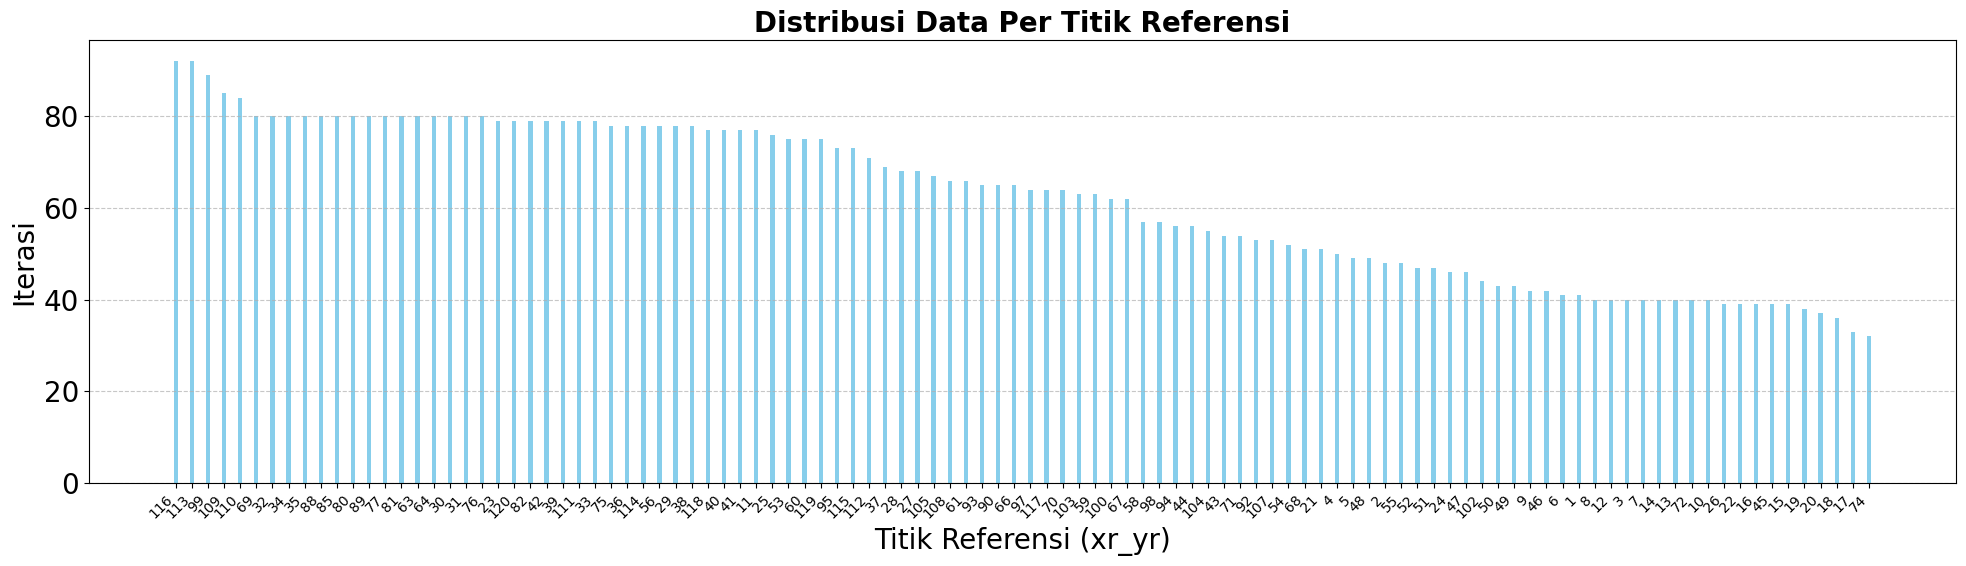

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Buat posisi X dengan spacing 1.2 (bisa diubah sesuai kebutuhan)
spacing = 3
x = np.arange(len(frequency_df)) * spacing

plt.rcParams.update({
    'font.size': 18,
    'figure.figsize': (20, 6),  # sedikit dipanjangkan lagi
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 10,
    'ytick.labelsize': 20
})

fig, ax = plt.subplots()
ax.bar(x, frequency_df['count'], width=0.8, color='skyblue')
ax.set_title('Distribusi Data Per Titik Referensi')
ax.set_xlabel('Titik Referensi (xr_yr)')
ax.set_ylabel('Iterasi')
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(frequency_df['reference_point'], rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [57]:
data['rssi_ap_dosen'].unique()

array([  nan,  -96.,  -94.,  -95.,  -92.,  -97.,  -90.,  -89.,  -91.,
        -93.,  -86.,  -88.,  -87.,  -81.,  -82.,  -83.,  -84.,  -85.,
        -79.,  -80.,  -78.,  -77.,  -75.,  -70.,  -71.,  -72.,  -73.,
        -74.,  -63.,  -64.,  -62.,  -76.,  -98.,  -99., -100.,  -69.,
        -66.,  -67.,  -65.,  -68.,  -37.,  -41.,  -40.,  -36.,  -38.,
        -35.,  -39.,  -43.,  -42.,  -44.,  -47.,  -45.])

In [58]:
data['rssi_ap_digilab'].unique()

array([-64., -63., -65., -62., -61., -60., -67., -71.,  nan, -70., -66.,
       -68., -69., -74., -75., -72., -73., -59., -57., -58., -43., -42.,
       -44., -45., -41., -39., -50., -51., -46., -47., -52., -53., -54.,
       -55., -56., -76., -77., -81., -80., -79., -78., -49., -48., -83.,
       -82., -86., -87., -84., -85., -89., -88., -90., -91., -34., -36.,
       -37., -40., -38., -35.])

In [59]:
data['reference_point'].unique()

array(['RP1', 'RP2', 'RP3', 'RP4', 'RP5', 'RP6', 'RP7', 'RP8', 'RP9',
       'RP10', 'RP29', 'RP30', 'RP37', 'RP11', 'RP12', 'RP13', 'RP14',
       'RP15', 'RP16', 'RP17', 'RP18', 'RP19', 'RP20', 'RP38', 'RP36',
       'RP42', 'RP41', 'RP40', 'RP39', 'RP35', 'RP33', 'RP34', 'RP32',
       'RP31', 'RP113', 'RP114', 'RP115', 'RP118', 'RP119', 'RP120',
       'RP53', 'RP54', 'RP55', 'RP58', 'RP59', 'RP60', 'RP77', 'RP76',
       'RP75', 'RP81', 'RP82', 'RP66', 'RP67', 'RP70', 'RP71', 'RP72',
       'RP56', 'RP61', 'RP63', 'RP64', 'RP68', 'RP69', 'RP74', 'RP80',
       'RP89', 'RP85', 'RP88', 'RP90', 'RP28', 'RP110', 'RP105', 'RP100',
       'RP95', 'RP109', 'RP108', 'RP103', 'RP104', 'RP99', 'RP98', 'RP93',
       'RP45', 'RP44', 'RP43', 'RP52', 'RP51', 'RP46', 'RP47', 'RP27',
       'RP25', 'RP23', 'RP21', 'RP22', 'RP24', 'RP26', 'RP50', 'RP49',
       'RP48', 'RP107', 'RP102', 'RP94', 'RP97', 'RP92', 'RP111', 'RP112',
       'RP117', 'RP116'], dtype=object)

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

C:\Users\laure\AppData\Local\Temp\ipykernel_14252\82709589.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  serving_ap_df = data.groupby('reference_point', group_keys=False).apply(determine_serving_ap)


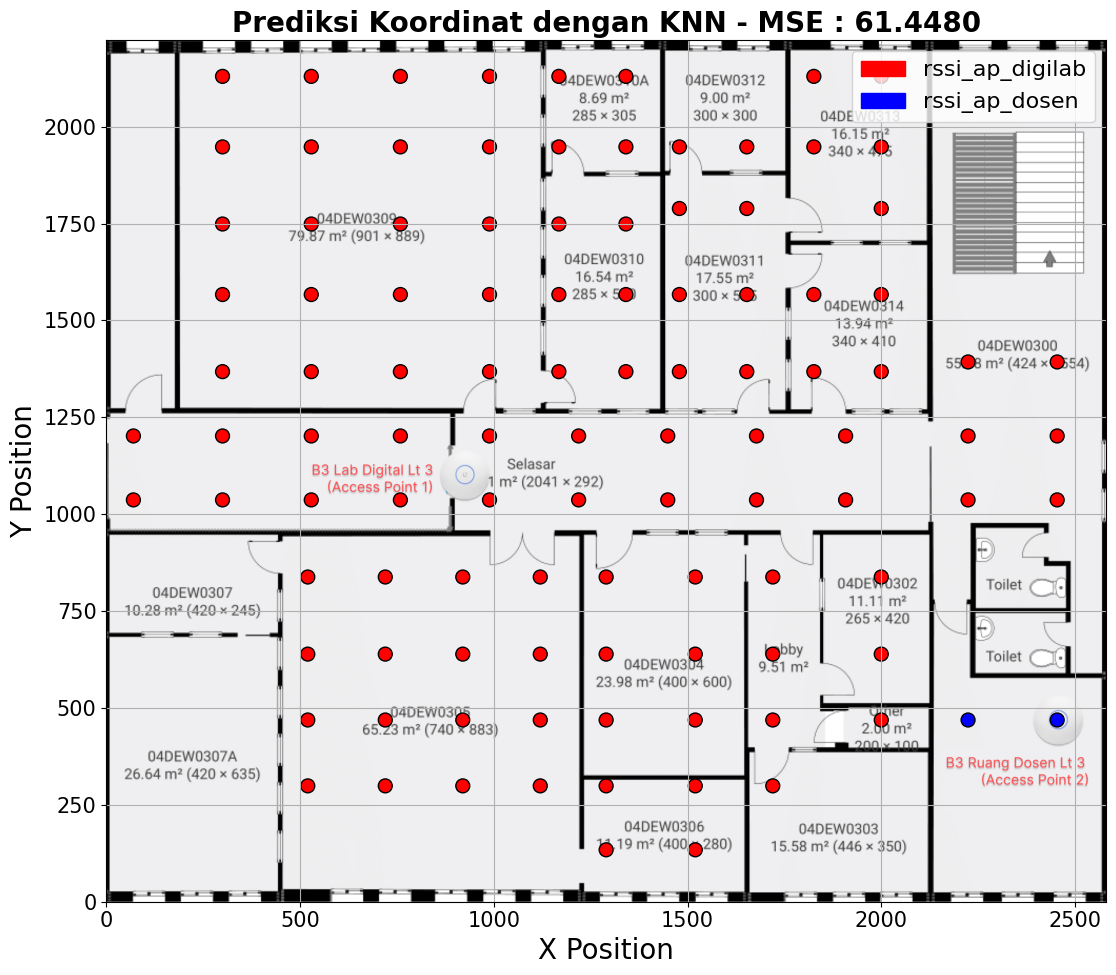

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.image as mpimg


# Load floorplan image
floorplan = mpimg.imread('Data/floorplan.png')

mpl.rcParams['font.size']       = 15
mpl.rcParams['axes.titlesize']  = 15
mpl.rcParams['axes.labelsize']  = 15
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['legend.fontsize'] = 15

# For each reference point, find the row where the maximum RSSI value is observed (across both APs)
def determine_serving_ap(group):
    group['best_rssi'] = group[['rssi_ap_digilab', 'rssi_ap_dosen']].max(axis=1)
    idx = group['best_rssi'].idxmax()
    return group.loc[[idx]]

# Apply this logic group-wise
serving_ap_df = data.groupby('reference_point', group_keys=False).apply(determine_serving_ap)

# Identify which AP had the strongest RSSI
serving_ap_df['serving_ap'] = serving_ap_df[['rssi_ap_digilab', 'rssi_ap_dosen']].idxmax(axis=1)
serving_ap_df['color'] = serving_ap_df['serving_ap'].map({
    'rssi_ap_digilab': 'red',
    'rssi_ap_dosen': 'blue'
})

# Plot the results
plt.figure(figsize=(12, 10))
plt.imshow(floorplan, extent=[0, floorplan.shape[1], floorplan.shape[0], 0])

# Scatter plot untuk reference points
plt.scatter(
    serving_ap_df['xr'], serving_ap_df['yr'],
    c=serving_ap_df['color'], s=100, edgecolors='black'
)

# Custom legend dengan fontsize=9
red_patch = mpatches.Patch(color='red', label='rssi_ap_digilab')
blue_patch = mpatches.Patch(color='blue', label='rssi_ap_dosen')
plt.legend(handles=[red_patch, blue_patch], loc='upper right', fontsize=16)

# Invert Y-axis
plt.gca().invert_yaxis()

# Title dan labels dengan fontsize=9 (opsional, karena sudah di-rc)
plt.title("Prediksi Koordinat dengan KNN - MSE : 61.4480", fontsize=20)
plt.xlabel("X Position", fontsize=20)
plt.ylabel("Y Position", fontsize=20)
plt.grid(True)

plt.tight_layout()
plt.show()


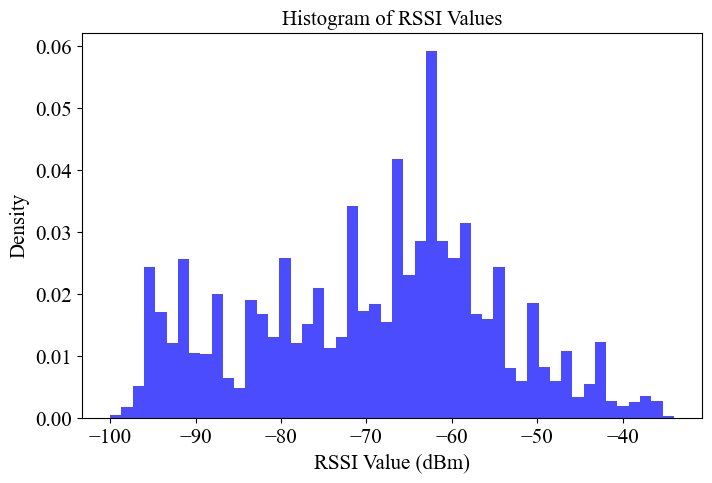

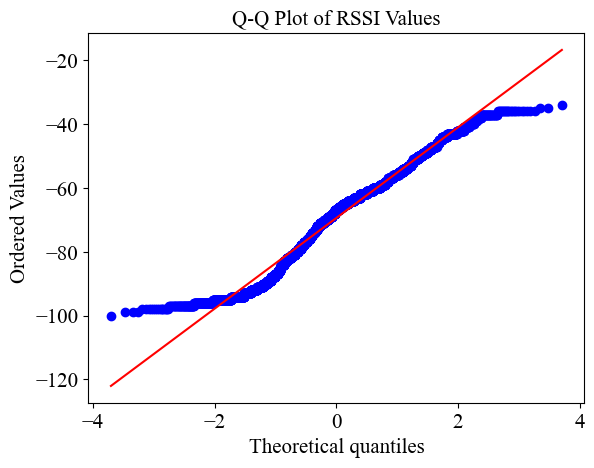

RSSI Skewness: -0.1302
RSSI Kurtosis: -0.6852


In [62]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import skew, kurtosis

# Select RSSI columns (replace with actual column names from your dataset)
rssi_digilab = data["rssi_ap_digilab"]
rssi_dosen = data["rssi_ap_dosen"]

rssi_digilab = rssi_digilab[rssi_digilab > -200]
rssi_dosen = rssi_dosen[rssi_dosen > -200]

# Combine both RSSI columns for analysis
rssi_values = np.concatenate([rssi_digilab, rssi_dosen])

# 1️⃣ Histogram (Check RSSI Distribution)
plt.figure(figsize=(8, 5))
plt.hist(rssi_values, bins=50, color='blue', alpha=0.7, density=True)
plt.xlabel("RSSI Value (dBm)")
plt.ylabel("Density")
plt.title("Histogram of RSSI Values")
plt.show()

# 2️⃣ Q-Q Plot (Check for Normality)
stats.probplot(rssi_values, dist="norm", plot=plt)
plt.title("Q-Q Plot of RSSI Values")
plt.show()

# 3️⃣ Skewness & Kurtosis (Numerical Analysis)
rssi_skewness = skew(rssi_values)
rssi_kurtosis = kurtosis(rssi_values)

print(f"RSSI Skewness: {rssi_skewness:.4f}")  # >0 means right-skewed, <0 means left-skewed
print(f"RSSI Kurtosis: {rssi_kurtosis:.4f}")  # >3 means heavy-tailed (outliers)


## Handling Missing Values (NaN)

In [63]:
# Fill missing RSSI values
data['rssi_ap_digilab'] = data['rssi_ap_digilab'].fillna(-200)
data['rssi_ap_dosen'] = data['rssi_ap_dosen'].fillna(-200)

## Real AP Coordinates

In [64]:
ap_coordinates = {
    'DTE Staff (Digilab)': (867, 1122),
    'DTE Staff (Dosen)': (2454, 520)
}

## Relative Position Column Insertion

In [65]:
data = data[~data['reference_point'].isin(['RP74'])]

# Ensure the relative_position column exists with a default numeric value (-1 for unassigned)
data['relative_position'] = -1  # Using -1 to indicate unassigned values initially

# Define reference points that should be assigned a relative position of 0
zero_rps = (
    list(range(1, 21)) +   # RP1-20
    list(range(53, 57)) +  # RP53-56
    list(range(58, 62)) +  # RP58-61
    list(range(63, 65)) +  # RP63-64
    list(range(66, 73)) +  # RP66-72
    list(range(75, 78)) +  # RP75-77
    list(range(80, 89)) +  # RP80-88
    list(range(113, 116)) +  # RP113-115
    list(range(118, 121)) +  # RP118-120
    list(range(93, 96)) +
    list(range(98, 101)) +
    list(range(103, 106)) +
    list(range(108, 111)) 
)

# Define reference points that should be assigned a relative position of 1
one_rps = list(range(28, 43)) + [89, 90]  # RP28-42 and RP89-90


# Convert lists to sets for faster lookup
zero_rp_set = {f'RP{i}' for i in zero_rps}
one_rp_set = {f'RP{i}' for i in one_rps}

# Apply conditions to assign relative_position
data['relative_position'] = data['reference_point'].apply(
    lambda rp: 0 if rp in zero_rp_set else (1 if rp in one_rp_set else -1)
)

# Convert to integer type to ensure it's numeric
data['relative_position'] = data['relative_position'].astype(int)

# Check unique values to ensure no -1 remains
print("Unique values in relative_position:", data['relative_position'].unique())

# Check the first few rows to confirm the relative_position column was added correctly
print(data[['reference_point', 'relative_position']].head())

Unique values in relative_position: [ 0  1 -1]
  reference_point  relative_position
0             RP1                  0
1             RP1                  0
2             RP1                  0
3             RP1                  0
4             RP1                  0


In [66]:
# Convert the 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'])
# Convert to seconds since the epoch
data['time_numeric'] = data['time'].apply(lambda x: x.time())

## BSSID Mapping (Encoding)

In [67]:
# Define the mapping dictionary
bssid_mapping = {
    '70:a7:41:dc:8e:55': 1,
    '72:a7:41:9c:8e:55': 2,
    '70:a7:41:dc:77:cd': 3,
    '72:a7:41:9c:77:cd': 4
}

In [68]:
data['bssid'] = data['bssid'].map(bssid_mapping)
print(data[['bssid', 'bssid']].head())


   bssid  bssid
0      4      4
1      3      3
2      4      4
3      4      4
4      3      3


In [69]:
# Assuming 'reference_point' is your column name in the DataFrame
data['reference_point'] = data['reference_point'].str.replace('RP', '').astype(int)

# Check the result
print(data['reference_point'])

0         1
1         1
2         1
3         1
4         1
       ... 
6591    116
6592    116
6593    116
6594    116
6595    116
Name: reference_point, Length: 6564, dtype: int32


In [70]:
data.sample(10)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric
1946,2025-02-25 03:35:00.015666700+00:00,113,1,DTE Staff,1,11,1290,469,-200.0,-81.0,0,03:35:00.015666
2213,2025-02-25 04:09:45.647923800+00:00,118,7,DTE Staff,2,11,1520,469,-200.0,-78.0,0,04:09:45.647923
1570,2024-10-23 08:48:30.354439400+00:00,35,7,DTE Staff,3,11,1678,1037,-48.0,-200.0,1,08:48:30.354439
5856,2025-03-12 03:02:44.174949600+00:00,50,9,DTE Student,4,6,1341,1749,-67.0,-200.0,-1,03:02:44.174949
1563,2024-10-23 08:47:42.423019500+00:00,35,5,DTE Staff,1,1,1678,1037,-200.0,-81.0,1,08:47:42.423019
1990,2025-02-25 03:40:08.517393+00:00,113,14,DTE Student,4,1,1290,469,-63.0,-200.0,0,03:40:08.517393
3303,2025-03-01 02:36:22.005708800+00:00,67,18,DTE Staff,3,1,1826,2130,-69.0,-200.0,0,02:36:22.005708
5974,2025-03-12 03:31:03.529614700+00:00,107,1,DTE Staff,3,6,1120,299,-60.0,-200.0,-1,03:31:03.529614
5125,2025-03-11 06:53:14.415854100+00:00,45,8,DTE Student,4,6,1168,1749,-63.0,-200.0,-1,06:53:14.415854
6097,2025-03-12 03:57:09.239693600+00:00,94,11,DTE Student,4,6,520,639,-64.0,-200.0,0,03:57:09.239693


In [71]:
# # Save the final dataframe
# data.to_csv('data_preprocessed.csv', index=False)
# print(f"Data saved to {'data_preprocessed.csv'}")

## Handling Overlapping Data


In [72]:
print("Columns in DataFrame:", data.columns)
print("Shape of DataFrame:", data.shape)

Columns in DataFrame: Index(['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel',
       'xr', 'yr', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position',
       'time_numeric'],
      dtype='object')
Shape of DataFrame: (6564, 12)


In [73]:
df = data.iloc[:, [1, 2, 4, 5, 8 , 9, 10]]
print("\nColumns in X:", df.columns.tolist())

# df = encode_and_save_labels(df, 'reference_point')
df = df.rename(columns={'reference_point': 'label'})


Columns in X: ['reference_point', 'iteration', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']


In [74]:
df

,label,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position
0,1,3,4,11,-64.0,-200.0,0
1,1,1,3,11,-63.0,-200.0,0
2,1,1,4,11,-63.0,-200.0,0
3,1,2,4,11,-64.0,-200.0,0
4,1,2,3,11,-65.0,-200.0,0
...,...,...,...,...,...,...,...
6591,116,19,1,11,-200.0,-82.0,-1
6592,116,20,3,6,-65.0,-200.0,-1
6593,116,20,4,6,-65.0,-200.0,-1
6594,116,20,2,11,-200.0,-84.0,-1


### Are there overlapping points?

In [75]:
binned_data = df.copy()
binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
overlapping_points = overlapping_points[overlapping_points > 1]
overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

overlapping_data

,,,,,,relative_position
label,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,


In [76]:
# Delete overlapping data 
non_overlapping_mask = ~binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_points.index)
df = df[non_overlapping_mask]
df.shape

(6564, 7)

## Regression Model

### Feature Selection

In [77]:
X = data.iloc[:, [1, 4, 5, 8 , 9, 10]]
y = data.iloc[:, [6, 7]]


In [78]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']
Columns in y: ['xr', 'yr']


In [79]:
print(X.head())
print(X.dtypes)

   reference_point  bssid  channel  rssi_ap_digilab  rssi_ap_dosen  \
0                1      4       11            -64.0         -200.0   
1                1      3       11            -63.0         -200.0   
2                1      4       11            -63.0         -200.0   
3                1      4       11            -64.0         -200.0   
4                1      3       11            -65.0         -200.0   

   relative_position  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
reference_point        int32
bssid                  int64
channel                int64
rssi_ap_digilab      float64
rssi_ap_dosen        float64
relative_position      int32
dtype: object


### Robust Scaler + Assign Train & Validation 

In [80]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    

regression_data_scaled = RobustScaler().fit_transform(X)

dataset = CustomDataset(regression_data_scaled, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataset = CustomDataset(regression_data_scaled, y)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [81]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']
Columns in y: ['xr', 'yr']


### Split Training & Full Testing set

In [82]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Ensure y is a numpy array
y = np.array(y)  # Convert to numpy array if y is a pandas DataFrame or Series

# Step 1: Split the dataset into 70% training, 30% remaining (not final test set)
X_train, X_unused, y_train, y_unused = train_test_split(regression_data_scaled, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

# Step 2: Use 100% of the dataset as the test set
X_test = regression_data_scaled  # Full dataset as test set
y_test = y  # Full dataset labels

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]} (Full Dataset)")

Training set size: 4042
Test set size: 6564 (Full Dataset)


In [83]:
print(f"Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")


Training samples: 4042, Features: 6


### XGB Hyperparameter Tuning

In [84]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    max_depth=6,  # Increase depth for more complex patterns
    learning_rate=0.05,  # Reduce step size for better accuracy
    n_estimators=500  # More trees for better generalization
)

# Use MultiOutputRegressor to handle multiple targets
multi_xgb = MultiOutputRegressor(xgb_model)

In [85]:
# Define hyperparameters for tuning
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.01, 0.1, 0.3]
}

### Outlier Handling

In [86]:
def remove_outliers_before_training(X, y, threshold=1000):
    """Remove samples where MSE is an outlier before training the model."""
    # Predict rough initial values using a simple model to estimate errors
    temp_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
    temp_model.fit(X, y)
    y_pred = temp_model.predict(X)
    
    # Compute errors
    mse = np.mean((y - y_pred)**2, axis=1)
    
    # Keep only samples with MSE below the threshold
    mask = mse < threshold
    return X[mask], y[mask]

In [87]:
X_train, y_train = remove_outliers_before_training(X_train, y_train, threshold=1000)

### Model Training

In [88]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constr...
                                                                   max_depth=6,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=500,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=42, ...)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.1, 0.3],
                         'estimator__max_depth': [3, 4, 5],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [89]:
# Print the best parameters
print("Best parameters found by grid search:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_model = grid_search.best_estimator_

# Print all hyperparameters of the best model
print("\nAll hyperparameters of the best model:")
for i, estimator in enumerate(best_model.estimators_):
    print(f"\nEstimator for dimension {i+1} ({'x' if i==0 else 'y' if i==1 else 'z'}):")
    for param, value in estimator.get_params().items():
        print(f"  {param}: {value}")

Best parameters found by grid search:
estimator__learning_rate: 0.3
estimator__max_depth: 4
estimator__n_estimators: 300

All hyperparameters of the best model:

Estimator for dimension 1 (x):
  objective: reg:squarederror
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: None
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.3
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 4
  max_leaves: None
  min_child_weight: None
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: 300
  n_jobs: None
  num_parallel_tree: None
  random_state: 42
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: None
  tree_method: None
 

In [90]:
# Make predictions
y_pred = best_model.predict(X_test)

### Model Evaluation

In [91]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Number of predictions: {len(y_pred)}")
print(f"\nOverall Mean Squared Error: {mse}")

# Calculate and print MSE for each coordinate
for i, coord in enumerate(['x', 'y']):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    print(f"MSE for {coord}: {mse}")

Number of predictions: 6564

Overall Mean Squared Error: 61.00859451293945
MSE for x: 12.378327369689941
MSE for y: 109.63886260986328


In [92]:
# # Function to compute MSE statistics and remove outliers
# def remove_mse_outliers(y_true, y_pred, percentile=95):
#     """Removes high-MSE outliers based on a given percentile threshold."""
    
#     # Compute MSE per sample
#     mse_per_sample = np.mean((y_true - y_pred) ** 2, axis=1)
    
#     # Compute MSE statistics BEFORE filtering
#     stats_before = {
#         "Mean MSE": np.mean(mse_per_sample),
#         "Median MSE": np.median(mse_per_sample),
#         "Max MSE": np.max(mse_per_sample),
#         "Min MSE": np.min(mse_per_sample),
#         "Std Dev MSE": np.std(mse_per_sample),
#     }

#     # Compute percentile threshold for outlier detection
#     threshold = np.percentile(mse_per_sample, percentile)
    
#     # Create mask for non-outliers (values below the threshold)
#     mask = mse_per_sample < threshold
    
#     # Apply mask to filter `y_test` and `y_pred`
#     y_test_filtered = y_true[mask]
#     y_pred_filtered = y_pred[mask]
    
#     # Compute MSE statistics AFTER filtering
#     mse_per_sample_filtered = mse_per_sample[mask]
#     stats_after = {
#         "Mean MSE": np.mean(mse_per_sample_filtered),
#         "Median MSE": np.median(mse_per_sample_filtered),
#         "Max MSE": np.max(mse_per_sample_filtered),
#         "Min MSE": np.min(mse_per_sample_filtered),
#         "Std Dev MSE": np.std(mse_per_sample_filtered),
#     }

#     # Display comparison of MSE statistics
#     mse_comparison = pd.DataFrame([stats_before, stats_after], index=["Before Outlier Removal", "After Outlier Removal"])
    
#     return mse_comparison, y_test_filtered, y_pred_filtered

# # Ensure correct test set subset matches prediction size
# mse_stats, y_test_filtered, y_pred_filtered = remove_mse_outliers(y_test[:len(y_pred)], y_pred, percentile=95)

# # Display MSE statistics comparison
# print("\nMSE Statistics Before and After Outlier Removal:")
# print(mse_stats)

# # Compute new MSE after outlier removal
# mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
# print(f"\nOverall Mean Squared Error (After Outlier Removal): {mse_filtered}")

# # Calculate and print MSE for each coordinate (x, y)
# for i, coord in enumerate(['x', 'y']):
#     mse_coord = mean_squared_error(y_test_filtered[:, i], y_pred_filtered[:, i])
#     print(f"MSE for {coord} (After Outlier Removal): {mse_coord}")


### Floorplan Prediction visualization

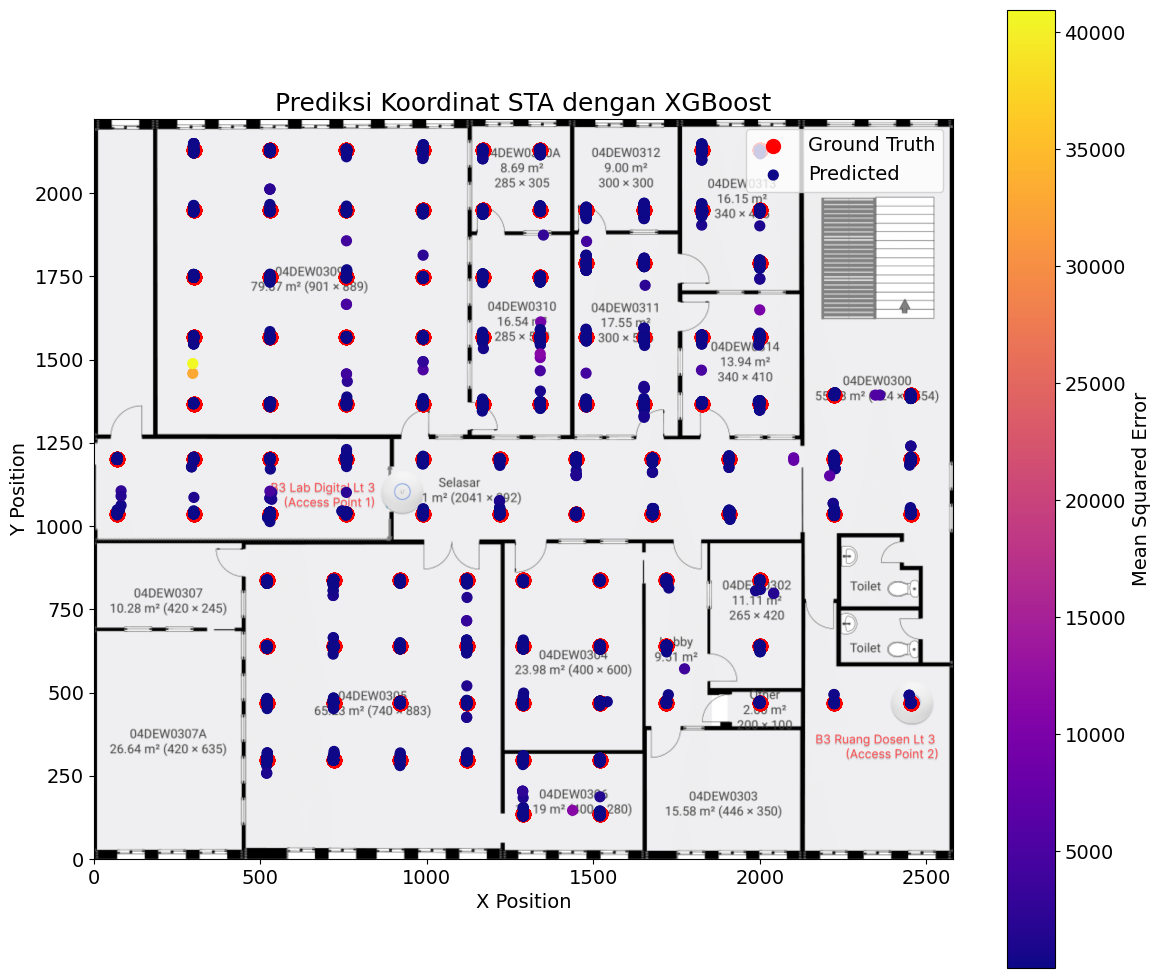

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
from matplotlib.colors import Normalize
from sklearn.metrics import mean_squared_error

# 1) Reset to default style (wipes out any Times New Roman rc settings)
plt.style.use('default')

# 2) Increase all the key font sizes
mpl.rcParams.update({
    'font.size'       : 14,   # base font size for text (e.g. tick labels)
    'axes.titlesize'  : 18,   # title
    'axes.labelsize'  : 14,   # x/y labels
    'xtick.labelsize' : 14,   # x-tick numbers
    'ytick.labelsize' : 14,   # y-tick numbers
    'legend.fontsize' : 14,   # legend texts
})

def plot_2d_ap_positions_with_floorplan(y_true, y_pred, floorplan_path, real_to_pixel_scale=None):
    # load & convert
    floorplan = cv2.cvtColor(cv2.imread(floorplan_path), cv2.COLOR_BGR2RGB)
    H, W, _ = floorplan.shape

    # optional scaling
    if real_to_pixel_scale is not None:
        y_true = y_true * real_to_pixel_scale
        y_pred = y_pred * real_to_pixel_scale

    # per-point MSE
    mse = np.mean((y_true - y_pred)**2, axis=1)

    # flip Y so origin='lower' works
    y_true_fl = y_true.copy();  y_true_fl[:,1] = H - y_true[:,1]
    y_pred_fl = y_pred.copy();  y_pred_fl[:,1] = H - y_pred[:,1]

    # plot
    plt.figure(figsize=(12,10))
    plt.imshow(floorplan,
               extent=[0, W, 0, H],
               origin='lower')

    plt.scatter(y_true_fl[:,0], y_true_fl[:,1],
                c='red', s=100, label='Ground Truth')

    norm = Normalize(vmin=mse.min(), vmax=mse.max())
    sc = plt.scatter(y_pred_fl[:,0], y_pred_fl[:,1],
                     c=mse, norm=norm, cmap='plasma',
                     s=50, label='Predicted')

    cbar = plt.colorbar(sc)
    cbar.set_label('Mean Squared Error', fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    overall_mse = mean_squared_error(y_true, y_pred)
    plt.title('Prediksi Koordinat STA dengan XGBoost')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    

plot_2d_ap_positions_with_floorplan(y_test, y_pred, "Data/floorplan.png")


In [94]:
a

NameError: name 'a' is not defined

### Save the Model

In [ ]:
# Create a DataFrame for predictions
predicted_df = pd.DataFrame({
    'xp': y_pred[:, 0],  # Predicted x-coordinate
    'yp': y_pred[:, 1]   # Predicted y-coordinate
})

# Reset index to ensure alignment before merging
predicted_df = predicted_df.reset_index(drop=True)
merged_data = data.copy().reset_index(drop=True)

# Ensure the row count matches before merging
if len(predicted_df) < len(merged_data):
    merged_data = merged_data.iloc[:len(predicted_df)]  # Trim extra rows

# Add predictions while ensuring proper alignment
merged_data[['xp', 'yp']] = predicted_df.values

# Verify
print(merged_data[['xr', 'yr', 'xp', 'yp']].sample(5))  # Check first few rows

        xr    yr           xp           yp
2379  1520   838  1519.991821   837.385193
4519   720   838   719.555359   830.422791
3508  1479  1948  1479.060181  1942.253296
956    989  1567   989.154785  1568.150024
5814  1341  1749  1341.300903  1746.892456


In [ ]:
merged_data.shape

(6564, 14)

In [ ]:
merged_data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
2359,2025-02-25 04:29:16.392186900+00:00,120,6,DTE Staff,3,1,1520,838,-59.0,-200.0,0,04:29:16.392186,1520.036987,838.841003
850,2024-10-23 03:22:26.589746+00:00,14,18,DTE Student,4,11,759,1948,-67.0,-200.0,0,03:22:26.589746,758.841797,1949.355469
3696,2025-03-01 03:41:49.118796300+00:00,64,1,DTE Staff,1,11,1826,1567,-200.0,-87.0,0,03:41:49.118796,1825.970947,1567.933472
5909,2025-03-12 03:19:29.835530200+00:00,48,9,DTE Staff,3,6,1341,1368,-54.0,-200.0,-1,03:19:29.835530,1340.997681,1366.348267
972,2024-10-23 04:02:44.915854400+00:00,18,4,DTE Student,4,11,989,1749,-61.0,-200.0,0,04:02:44.915854,989.020264,1744.733521


In [ ]:
# Create a new dataframe from merged_data
woi_filtered_data = merged_data.copy()

# Count the number of rows before filtering
rows_before = len(woi_filtered_data)

# Remove rows where the difference in either yr-yp or xr-xp is more than 20
woi_filtered_data = woi_filtered_data[
    (abs(woi_filtered_data['yr'] - woi_filtered_data['yp']) < 5) &
    (abs(woi_filtered_data['xr'] - woi_filtered_data['xp']) < 5)
]

# Count the number of rows after filtering
rows_after = len(woi_filtered_data)

# Calculate the number of removed rows
rows_removed = rows_before - rows_after

# Display results
print(f"Rows removed: {rows_removed}")
print(f"Rows remaining: {rows_after}")


Rows removed: 1040
Rows remaining: 5524


In [ ]:
woi_filtered_data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
4860,2025-03-03 08:17:10.595447900+00:00,104,19,DTE Student,4,6,920,639,-56.0,-200.0,0,08:17:10.595447,919.922058,641.001648
5975,2025-03-12 03:35:46.118426300+00:00,107,14,DTE Student,4,6,1120,299,-60.0,-200.0,-1,03:35:46.118426,1119.954102,295.213745
1422,2024-10-23 07:36:13.404744500+00:00,40,9,DTE Staff,3,11,2224,1202,-79.0,-200.0,1,07:36:13.404744,2223.974609,1199.480835
3147,2025-03-01 02:12:58.180339600+00:00,82,11,DTE Staff,1,11,2000,838,-200.0,-76.0,0,02:12:58.180339,1999.977295,837.335510
2378,2025-02-25 04:31:18.836489400+00:00,120,11,DTE Staff,3,1,1520,838,-57.0,-200.0,0,04:31:18.836489,1520.029907,837.663696


In [ ]:
# # Extract additional columns **including raw RSSI values** from `data`
# additional_columns = data.loc[:, ['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel', 
#                                 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']]

# # Ensure `additional_columns` has the same number of rows as `y_test_filtered`
# additional_columns = additional_columns.iloc[:len(y_test_filtered)].reset_index(drop=True)

# # Create the comparison dataframe using only the filtered data
# comparison_df = pd.DataFrame({
#     'xr': y_test_filtered[:, 0],  # Actual x-coordinate
#     'yr': y_test_filtered[:, 1],  # Actual y-coordinate
#     'xp': y_pred_filtered[:, 0],  # Predicted x-coordinate
#     'yp': y_pred_filtered[:, 1]  # Predicted y-coordinate
# })

# # Ensure `comparison_df` has the same number of rows
# comparison_df = comparison_df.iloc[:len(additional_columns)].reset_index(drop=True)

# # Concatenate additional columns (with raw RSSI) with `comparison_df`
# comparison_df = pd.concat([additional_columns, comparison_df], axis=1)

# # Display the updated comparison table shape
# comparison_df.shape


In [ ]:
# # Identify if xp or yp contain -1
# columns_with_neg1 = (comparison_df[['xp', 'yp']] == -1).any()

# # Display only if `xp` or `yp` contain -1
# print("\nColumns containing -1 values (xp and yp only):")
# print(columns_with_neg1[columns_with_neg1].index.tolist())  # List of affected columns

# # Count how many rows contain -1 in `xp` or `yp`
# num_rows_with_neg1 = (comparison_df[['xp', 'yp']] == -1).any(axis=1).sum()
# print(f"\nNumber of rows containing -1 in xp or yp: {num_rows_with_neg1}")

In [ ]:
# # Drop rows where any column contains -1 (invalid predictions)
# comparison_df = comparison_df[(comparison_df != -1).all(axis=1)]
# comparison_df.sample(7)

In [ ]:
# Convert xp and yp to integers based on their decimal value
woi_filtered_data['xp'] = np.where(woi_filtered_data['xp'] % 1 >= 0.5, np.ceil(woi_filtered_data['xp']), np.floor(woi_filtered_data['xp'])).astype(int)
woi_filtered_data['yp'] = np.where(woi_filtered_data['yp'] % 1 >= 0.5, np.ceil(woi_filtered_data['yp']), np.floor(woi_filtered_data['yp'])).astype(int)

# Verify conversion
print(woi_filtered_data[['xp', 'yp']].sample(5))  # Check the first few rows


        xp    yp
3082  2000   640
2061  1290   638
1411  2224  1202
1640  1449  1037
6471  1520   294


In [ ]:
# Save the new dataset to a CSV file
woi_filtered_data.to_csv('Data/data_with_predictions.csv', index=False)

print("New CSV file 'data_with_predictions.csv' saved successfully!")

New CSV file 'data_with_predictions.csv' saved successfully!


In [ ]:
merged_data['reference_point'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  29,  30,  37,
        11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  38,  36,  42,
        41,  40,  39,  35,  33,  34,  32,  31, 113, 114, 115, 118, 119,
       120,  53,  54,  55,  58,  59,  60,  77,  76,  75,  81,  82,  66,
        67,  70,  71,  72,  56,  61,  63,  64,  68,  69,  80,  89,  85,
        88,  90,  28, 110, 105, 100,  95, 109, 108, 103, 104,  99,  98,
        93,  45,  44,  43,  52,  51,  46,  47,  27,  25,  23,  21,  22,
        24,  26,  50,  49,  48, 107, 102,  94,  97,  92, 111, 112, 117,
       116])

In [ ]:
woi_filtered_data['reference_point'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  29,  30,  37,
        11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  38,  36,  42,
        41,  40,  39,  35,  33,  34,  32,  31, 113, 114, 115, 118, 119,
       120,  53,  54,  55,  58,  59,  60,  77,  76,  75,  81,  82,  66,
        67,  70,  71,  72,  56,  61,  63,  64,  68,  69,  80,  89,  85,
        88,  90,  28, 110, 105, 100,  95, 109, 108, 103, 104,  99,  98,
        93,  45,  44,  43,  52,  51,  46,  47,  27,  25,  23,  21,  22,
        24,  26,  50,  49,  48, 107, 102,  94,  97,  92, 111, 112, 117,
       116])

# RSSI Prediction Model

## Remove NaN Values

In [ ]:
# Remove rows with any NaN values
filtered_data = woi_filtered_data.dropna()

print(f"Filtered dataset saved successfully with {filtered_data.shape[0]} rows and {filtered_data.shape[1]} columns.")

Filtered dataset saved successfully with 5524 rows and 14 columns.


In [ ]:
filtered_data.head()

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
0,2024-10-17 08:38:31.952562400+00:00,1,3,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:38:31.952562,300,1368
1,2024-10-17 08:39:38.608620600+00:00,1,1,DTE Staff,3,11,300,1368,-63.0,-200.0,0,08:39:38.608620,300,1369
2,2024-10-17 08:39:45.832622300+00:00,1,1,DTE Student,4,11,300,1368,-63.0,-200.0,0,08:39:45.832622,300,1368
3,2024-10-17 08:40:03.157448400+00:00,1,2,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:40:03.157448,300,1368
4,2024-10-17 08:40:08.170180900+00:00,1,2,DTE Staff,3,11,300,1368,-65.0,-200.0,0,08:40:08.170180,300,1370


In [ ]:
filtered_data.shape

(5524, 14)

In [ ]:
filtered_data['xr'].unique()

array([ 300,  529,  989, 1908,  759, 1678, 2454, 2224, 1449, 1219, 1290,
       1520, 1479, 1653, 1720, 2000, 1826, 1120,  920,  720,  520, 1168,
       1341,   70], dtype=int64)

In [ ]:
filtered_data['xp'].unique()

array([ 300,  529,  530,  989, 1908, 1906, 1907,  759,  760,  758,  988,
        990, 1909, 1678, 1679, 2454, 2223, 2224, 2222, 2225, 1449, 1446,
       1219, 1218, 1220, 1290, 1291, 1519, 1520, 1521, 1479, 1478, 1653,
       1654, 1652, 1720, 1719, 1723, 1722, 1999, 2001, 2000, 1829, 1826,
       1825, 1828, 1998, 1996, 2453, 2455, 1120,  920,  921,  720,  520,
        721,  521, 1168, 1167, 1169, 1341, 1339, 1338,   70,   71,  299,
       1340,  719,  519, 1518])

## Transmit Power

In [ ]:
reference_point_power_map = {
    "RP1-10": (30, 20),         # Digilab only, max boost
    "RP10-20": (30, 30),        # Both weak
    "RP21-28": (30, 20),
    "RP29-38": (30, 23),
    "RP39-42, 89-90": (20, 30), # Dosen dominant
    "RP43-45, 48-50": (26, 20),
    "RP46-47, 51-52": (23, 20),
    "RP53-55, 58-60": (23, 20),
    "RP56, 61": (23, 20),
    "RP63-64, 68-69": (26, 26),
    "RP85, 88": (20, 30),       # Dosen only
    "RP75-77, 80-82": (23, 30),
    "RP92-95, 97-100": (26, 26),
    "RP102-105, 107-110": (30, 23),
    "RP111-112, 116-117": (23, 30),
    "RP113-115, 118-120": (26, 26),
    "RP66-67, 70-72": (30, 20)
}



# Function to assign transmit power based on reference point
def assign_transmit_power(reference_point):
    reference_point_str = str(reference_point)  # Ensure it is a string

    for rp_range, (pow_digilab, pow_dosen) in reference_point_power_map.items():
        rp_list = rp_range.replace("RP", "").replace("-", ",").split(", ")
        rp_numbers = set()

        for rp in rp_list:
            if "," in rp:
                start, end = map(int, rp.split(","))
                rp_numbers.update(range(start, end + 1))
            else:
                rp_numbers.add(int(rp))
        
        if int(reference_point_str.replace("RP", "")) in rp_numbers:
            return pow_digilab, pow_dosen
    return None, None  # Default if not found

# Apply function to filtered_data
filtered_data[['pow_ap_digilab', 'pow_ap_dosen']] = filtered_data['reference_point'].astype(str).apply(
    lambda rp: pd.Series(assign_transmit_power(rp))
)

# Convert assigned transmit power values to integers
filtered_data['pow_ap_digilab'] = filtered_data['pow_ap_digilab'].astype(int)
filtered_data['pow_ap_dosen'] = filtered_data['pow_ap_dosen'].astype(int)


In [ ]:
# # Define a mapping for BSSID and corresponding transmit power
# bssid_to_transmit_power = {
#     1: 23,  # AP Dosen staff
#     2: 20,  # AP Dosen student
#     3: 30,  # AP Digilab staff
#     4: 26   # AP Digilab student
# }

# # Assign transmit power based on BSSID
# filtered_data['transmit_power'] = filtered_data['bssid'].map(bssid_to_transmit_power)

# # Function to adjust RSSI based on transmit power
# def adjust_rssi(rssi, transmit_power):
#     if rssi == -200:  # Skip adjustment if RSSI is already lost
#         return -200
    
#     # Compute RSSI adjustment based on transmit power
#     adjustment_map = {30: 3, 26: 0, 23: -3, 20: -6}
#     adjustment = adjustment_map.get(transmit_power, 0)
    
#     # Apply adjustment and enforce the minimum RSSI limit
#     new_rssi = rssi + adjustment
#     return new_rssi if new_rssi > -100 else -200

# # Apply the function to rssi_ap_digilab and rssi_ap_dosen
# filtered_data['rssi_ap_digilab'] = filtered_data.apply(
#     lambda row: adjust_rssi(row['rssi_ap_digilab'], row['transmit_power']), axis=1
# )
# filtered_data['rssi_ap_dosen'] = filtered_data.apply(
#     lambda row: adjust_rssi(row['rssi_ap_dosen'], row['transmit_power']), axis=1
# )

# filtered_data


## Real AP Coordinates

In [ ]:
# Define the AP coordinates based on BSSID values
ap_coordinates = {
    1: (2454, 520),  # AP Dosen
    2: (2454, 520),  # AP Dosen
    3: (867, 1122),  # AP Digilab
    4: (867, 1122)   # AP Digilab
}

# Add the 'ap_x' and 'ap_y' columns to filtered_data based on bssid
filtered_data['ap_x'] = filtered_data['bssid'].map(lambda b: ap_coordinates.get(b, (None, None))[0])
filtered_data['ap_y'] = filtered_data['bssid'].map(lambda b: ap_coordinates.get(b, (None, None))[1])


In [ ]:
filtered_data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp,pow_ap_digilab,pow_ap_dosen,ap_x,ap_y
1558,2024-10-23 08:47:13.452682400+00:00,35,4,DTE Staff,3,11,1678,1037,-50.0,-200.0,1,08:47:13.452682,1678,1041,30,23,867,1122
694,2024-10-23 02:50:19.644143800+00:00,11,10,DTE Staff,2,1,759,1368,-200.0,-94.0,0,02:50:19.644143,759,1369,30,30,2454,520
1753,2024-10-23 09:10:55.585805400+00:00,34,13,DTE Staff,3,11,1449,1202,-45.0,-200.0,1,09:10:55.585805,1449,1204,30,23,867,1122
1186,2024-10-23 06:59:24.919196100+00:00,36,9,DTE Staff,3,11,1678,1202,-49.0,-200.0,1,06:59:24.919196,1678,1203,30,23,867,1122
2230,2025-02-25 04:11:47.724555600+00:00,118,12,DTE Staff,3,1,1520,469,-66.0,-200.0,0,04:11:47.724555,1521,472,26,26,867,1122


In [ ]:
# Count the number of rows before filtering
rows_before = len(filtered_data)

# Remove rows where both 'rssi_ap_digilab' and 'rssi_ap_dosen' are -200
filtered_data = filtered_data[~((filtered_data['rssi_ap_digilab'] == -200) & (filtered_data['rssi_ap_dosen'] == -200))]

# Count the number of rows after filtering
rows_after = len(filtered_data)

# Calculate the number of removed rows
rows_removed = rows_before - rows_after

# Display the number of rows removed
rows_removed

0

## Correlation Check

In [ ]:
print("Columns in DataFrame:", filtered_data.columns)
print("Shape of DataFrame:", filtered_data.shape)

Columns in DataFrame: Index(['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel',
       'xr', 'yr', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position',
       'time_numeric', 'xp', 'yp', 'pow_ap_digilab', 'pow_ap_dosen', 'ap_x',
       'ap_y'],
      dtype='object')
Shape of DataFrame: (5524, 18)


In [ ]:
print(filtered_data[['pow_ap_digilab', 'pow_ap_dosen', 'rssi_ap_digilab', 'rssi_ap_dosen']].corr())

                 pow_ap_digilab  pow_ap_dosen  rssi_ap_digilab  rssi_ap_dosen
pow_ap_digilab         1.000000     -0.524148         0.202077      -0.215103
pow_ap_dosen          -0.524148      1.000000        -0.226903       0.243124
rssi_ap_digilab        0.202077     -0.226903         1.000000      -0.984964
rssi_ap_dosen         -0.215103      0.243124        -0.984964       1.000000


### Are there overlapping points?

In [ ]:
# binned_data = df.copy()
# binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
# overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
# overlapping_points = overlapping_points[overlapping_points > 1]
# overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

# overlapping_data

In [ ]:
# # delete overlapping data 
# non_overlapping_mask = ~binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_points.index)
# df = df[non_overlapping_mask]
# df.shape

## Regression Model

### Feature Selection

In [ ]:
filtered_data.columns.tolist()

['time',
 'reference_point',
 'iteration',
 'ssid',
 'bssid',
 'channel',
 'xr',
 'yr',
 'rssi_ap_digilab',
 'rssi_ap_dosen',
 'relative_position',
 'time_numeric',
 'xp',
 'yp',
 'pow_ap_digilab',
 'pow_ap_dosen',
 'ap_x',
 'ap_y']

In [ ]:
df = filtered_data.copy()

In [ ]:
df = df.drop(columns=['xr','yr','time', 'time_numeric', 'ssid'])


In [ ]:
# Define AP coordinates
ap_coordinates = {
    'DTE Staff (Digilab)': (867, 1122),
    'DTE Staff (Dosen)': (2454, 520)
}

# Assign values based on the bssid column
df['ap_x'] = df['bssid'].apply(lambda x: 2454 if x in [1, 2] else 867)
df['ap_y'] = df['bssid'].apply(lambda x: 520 if x in [1, 2] else 1122)

df

,reference_point,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position,xp,yp,pow_ap_digilab,pow_ap_dosen,ap_x,ap_y
0,1,3,4,11,-64.0,-200.0,0,300,1368,30,20,867,1122
1,1,1,3,11,-63.0,-200.0,0,300,1369,30,20,867,1122
2,1,1,4,11,-63.0,-200.0,0,300,1368,30,20,867,1122
3,1,2,4,11,-64.0,-200.0,0,300,1368,30,20,867,1122
4,1,2,3,11,-65.0,-200.0,0,300,1370,30,20,867,1122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6557,116,19,3,6,-72.0,-200.0,-1,1520,137,23,30,867,1122
6560,116,20,3,6,-65.0,-200.0,-1,1521,132,23,30,867,1122
6561,116,20,4,6,-65.0,-200.0,-1,1521,132,23,30,867,1122
6562,116,20,2,11,-200.0,-84.0,-1,1520,134,23,30,2454,520


In [ ]:
df['xp'] = np.rint(df['xp']).astype(int)
df['yp'] = np.rint(df['yp']).astype(int)

df.sample(5)

,reference_point,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position,xp,yp,pow_ap_digilab,pow_ap_dosen,ap_x,ap_y
4199,88,14,3,1,-82.0,-200.0,0,2454,469,20,30,867,1122
3573,61,8,3,1,-69.0,-200.0,0,1653,1947,23,20,867,1122
1930,31,17,1,1,-200.0,-85.0,1,1219,1037,30,23,2454,520
1480,39,4,1,1,-200.0,-72.0,1,2224,1036,20,30,2454,520
6008,102,7,4,6,-56.0,-200.0,-1,920,298,30,23,867,1122


In [ ]:
# Define features (independent variables)
X = df[['reference_point', 'iteration', 'bssid', 'channel', 'xp', 'yp', 'relative_position', 'ap_x', 'ap_y', 'pow_ap_digilab', 'pow_ap_dosen']]  # Using coordinates & power to predict RSSI

# Define target variables (dependent variables)
y = df[['rssi_ap_digilab', 'rssi_ap_dosen']]  # Predicting RSSI values


In [ ]:
df.shape

(5524, 13)

In [ ]:
df.sample(1)

,reference_point,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position,xp,yp,pow_ap_digilab,pow_ap_dosen,ap_x,ap_y
176,4,20,3,11,-63.0,-200.0,0,300,1946,30,20,867,1122


In [ ]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'iteration', 'bssid', 'channel', 'xp', 'yp', 'relative_position', 'ap_x', 'ap_y', 'pow_ap_digilab', 'pow_ap_dosen']
Columns in y: ['rssi_ap_digilab', 'rssi_ap_dosen']


In [ ]:
# df_filtered = df.drop(columns=['iteration'])

# # Compute correlation matrix
# correlation_matrix = df_filtered.corr(method='pearson')

# import seaborn as sns

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Matrix")
# plt.show()

### Scaling with Robust Scaler

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, RobustScaler


class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
regression_data_scaled = RobustScaler().fit_transform(X)

dataset = CustomDataset(regression_data_scaled, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataset = CustomDataset(regression_data_scaled, y)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Ensure y is a numpy array
y = np.array(y)  # Convert to numpy array if y is a pandas DataFrame or Series

# Step 1: Split the dataset into 70% training, 30% remaining (not final test set)
X_train, X_unused, y_train, y_unused = train_test_split(regression_data_scaled, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

# Step 2: Use 100% of the dataset as the test set
X_test = regression_data_scaled  # Full dataset as test set
y_test = y  # Full dataset labels

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]} (Full Dataset)")

Training set size: 3402
Test set size: 5524 (Full Dataset)


In [ ]:
print(f"Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")


Training samples: 3402, Features: 11


### Hyperparameter Tuning

In [ ]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
# Use MultiOutputRegressor to handle multiple targets
multi_xgb = MultiOutputRegressor(xgb_model)

In [ ]:
# Define hyperparameters for tuning
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.01, 0.1, 0.3]
}

### Model Training

In [ ]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constr...
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=42, ...)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.1, 0.3],
                         'estimator__max_depth': [3, 4, 5],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [ ]:
# Print the best parameters
print("Best parameters found by grid search:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_model = grid_search.best_estimator_

# Print all hyperparameters of the best model
print("\nAll hyperparameters of the best model:")
for i, estimator in enumerate(best_model.estimators_):
    print(f"\nEstimator for dimension {i+1} ({'digilab' if i==0 else 'dosen' if i==1 else 'z'}):")
    for param, value in estimator.get_params().items():
        print(f"  {param}: {value}")

Best parameters found by grid search:
estimator__learning_rate: 0.3
estimator__max_depth: 5
estimator__n_estimators: 200

All hyperparameters of the best model:

Estimator for dimension 1 (digilab):
  objective: reg:squarederror
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: None
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.3
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 5
  max_leaves: None
  min_child_weight: None
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: 200
  n_jobs: None
  num_parallel_tree: None
  random_state: 42
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: None
  tree_method: 

In [ ]:
y_pred_rssi = best_model.predict(X_test)

In [ ]:
print(f"Number of predictions: {len(y_pred_rssi)}")

Number of predictions: 5524


In [ ]:
# Compute MSE per sample (without axis=1, since it's 1D)
mse_per_sample = (y_test[:len(y_pred_rssi)] - y_pred_rssi) ** 2

# Compute MSE statistics BEFORE filtering
stats_before = {
    "Mean MSE": np.mean(mse_per_sample),
    "Median MSE": np.median(mse_per_sample),
    "Max MSE": np.max(mse_per_sample),
    "Min MSE": np.min(mse_per_sample),
    "Std Dev MSE": np.std(mse_per_sample),
}

print(stats_before)


{'Mean MSE': 0.5190360974937166, 'Median MSE': 0.011736166576156393, 'Max MSE': 129.73330268223071, 'Min MSE': 0.0, 'Std Dev MSE': 3.9011242253878207}


### Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate error metrics
mse = mean_squared_error(y_test, y_pred_rssi)

print(f"Number of predictions: {len(y_pred_rssi)}")

rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rssi)
r2 = r2_score(y_test, y_pred_rssi)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Number of predictions: 5524
Mean Squared Error (MSE): 0.5190
Root Mean Squared Error (RMSE): 0.7204
Mean Absolute Error (MAE): 0.3211
R² Score: 0.9999


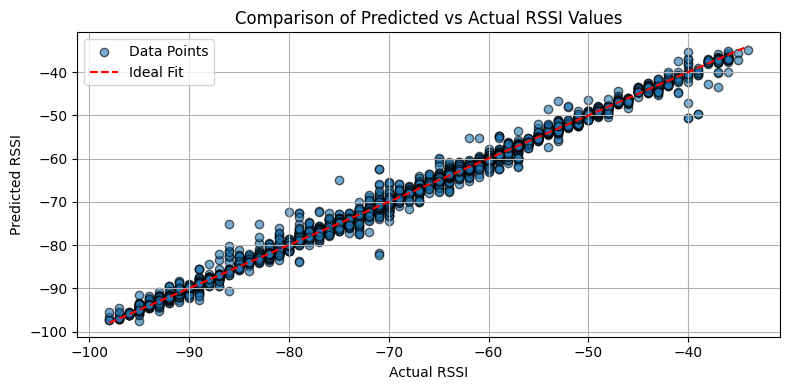

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure y_test and y_pred_rssi are 1D arrays
combined_actual = y_test
combined_predicted = y_pred_rssi

mask = (combined_actual != -200) & (combined_predicted != -200)
combined_actual = combined_actual[mask]
combined_predicted = combined_predicted[mask]

# Create the scatterplot
plt.figure(figsize=(8, 4))
plt.scatter(combined_actual, combined_predicted, alpha=0.6, edgecolors='k', label="Data Points")
plt.plot([combined_actual.min(), combined_actual.max()],
         [combined_actual.min(), combined_actual.max()], color='red', linestyle='--', label="Ideal Fit")
plt.title("Comparison of Predicted vs Actual RSSI Values")
plt.xlabel("Actual RSSI")
plt.ylabel("Predicted RSSI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 1. Get max RSSI across APs (axis=1 means row-wise max)
df = df.copy()
df['predicted_rssi'] = y_pred_rssi.max(axis=1)

# 2. Group by reference_point, get best RSSI per location
max_rssi_per_location = df.groupby('reference_point')['predicted_rssi'].max()

# 3. Sum all max RSSIs to get total
total_predicted_rssi = max_rssi_per_location.sum()

# 4. Output
print(f"🔎 Total predicted RSSI (before optimization): {total_predicted_rssi:.4f}")


🔎 Total predicted RSSI (before optimization): -6213.1426


# Optimization using Genetic Algorithm

In [ ]:
path_testing = 'Data/case1_dataset.csv' 
testing = pd.read_csv(path_testing) 
print(testing.shape)

(1036, 12)


In [ ]:
woi_filtered_data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
5071,2025-03-03 08:53:51.970465300+00:00,93,18,DTE Staff,2,11,520,469,-200.0,-94.0,0,08:53:51.970465,521,469
3838,2025-03-01 04:00:36.341122900+00:00,69,4,DTE Student,4,1,2000,1567,-73.0,-200.0,0,04:00:36.341122,2000,1567
3573,2025-03-01 03:22:57.639532300+00:00,61,8,DTE Staff,3,1,1653,1948,-69.0,-200.0,0,03:22:57.639532,1653,1947
748,2024-10-23 02:59:19.933324600+00:00,12,7,DTE Student,4,11,759,1567,-62.0,-200.0,0,02:59:19.933324,759,1568
5722,2025-03-11 09:03:49.414318700+00:00,24,1,DTE Student,4,6,300,1202,-52.0,-200.0,-1,09:03:49.414318,300,1202


In [ ]:
df_final = woi_filtered_data.drop(columns=['time', 'time_numeric','ssid','xr','yr'])

In [ ]:
df_final.sample(5)

,reference_point,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position,xp,yp
4916,99,13,3,6,-60.0,-200.0,0,720,637
2375,120,10,3,1,-60.0,-200.0,0,1520,837
2522,54,12,3,1,-72.0,-200.0,0,1479,1567
4871,99,2,3,6,-59.0,-200.0,0,720,636
2920,76,14,4,1,-64.0,-200.0,0,1720,642


In [ ]:
# Filter the eval_data based on unique reference_points from testing
unique_rps = testing['reference_point'].unique()

print(unique_rps)

# Filter the eval_data to only include those reference points
df_final = df_final[df_final['reference_point'].isin(unique_rps)]

print("\nFiltered Dataset for Case 1:")
print(df_final.sample(10))
print(df_final.shape)

[ 1  2  3  6  7  8  9 11 12 13 14 16 17 18 19 85 88 45 44 43 49 48]

Filtered Dataset for Case 1:
      reference_point  iteration  bssid  channel  rssi_ap_digilab  \
5111               45         18      3        6            -63.0   
4163               88          5      4        1            -82.0   
4132               85         17      4        1            -88.0   
5081               45          2      4        6            -60.0   
41                  2          1      4       11            -61.0   
5910               48          9      4        6            -55.0   
4091               85          7      4        1            -90.0   
4151               88          2      3        1            -85.0   
96                  3          4      3       11            -64.0   
59                  2         10      4       11            -61.0   

      rssi_ap_dosen  relative_position    xp    yp  
5111         -200.0                 -1  1168  1748  
4163         -200.0                 

In [ ]:
# Filter out rows where either rssi_ap_digilab or rssi_ap_dosen is -200
df_filtered = df_final[(df_final['rssi_ap_digilab'] != -200) & (df_final['rssi_ap_dosen'] != -200)]

# Compute row-wise max and min RSSI across the two APs, excluding -200 values
df_final['max_rssi'] = df_final[['rssi_ap_digilab', 'rssi_ap_dosen']].apply(
    lambda row: max(row[row != -200]), axis=1)
df_final['min_rssi'] = df_final[['rssi_ap_digilab', 'rssi_ap_dosen']].apply(
    lambda row: min(row[row != -200]), axis=1)

# Now, for each reference_point, take the single highest max_rssi and the single lowest min_rssi
best_per_rp  = df_final.groupby('reference_point')['max_rssi'].max()
worst_per_rp = df_final.groupby('reference_point')['min_rssi'].min()

# Sum them up
total_max = best_per_rp.sum()
total_min = worst_per_rp.sum()

print(f"Total of per-RP max RSSI (excluding -200): {total_max:.4f}")
print(f"Total of per-RP min RSSI (excluding -200): {total_min:.4f}")


Total of per-RP max RSSI (excluding -200): -1275.0000
Total of per-RP min RSSI (excluding -200): -1662.0000


In [ ]:
# 1. Compute distances from each unique reference point to both APs

# Access Point coordinates (static)
ap_digilab = (867, 1122)
ap_dosen = (2454, 520)

# Get all unique location points (fingerprinting locations)
locations = df_final[['reference_point', 'xp', 'yp']].drop_duplicates()

# Compute distances and show sample
locations['dist_to_digilab'] = np.sqrt((locations['xp'] - ap_digilab[0])**2 + (locations['yp'] - ap_digilab[1])**2)
locations['dist_to_dosen'] = np.sqrt((locations['xp'] - ap_dosen[0])**2 + (locations['yp'] - ap_dosen[1])**2)

print("📍 Sample of distances to each AP:")
print(locations.head())


📍 Sample of distances to each AP:
    reference_point   xp    yp  dist_to_digilab  dist_to_dosen
0                 1  300  1368       618.065531    2314.912525
1                 1  300  1369       618.464227    2315.279033
4                 1  300  1370       618.864282    2315.645914
41                2  300  1566       720.156233    2394.542127
42                2  300  1568       721.391017    2395.416456


In [ ]:
# Filter the eval_data based on unique reference_points from testing
unique_rps = testing['reference_point'].unique()

print(unique_rps)

# Filter the eval_data to only include those reference points
locations = locations[locations['reference_point'].isin(unique_rps)]

print("\nFiltered Dataset for Case 1:")
print(locations.sample(10))
print(locations.shape)

[ 1  2  3  6  7  8  9 11 12 13 14 16 17 18 19 85 88 45 44 43 49 48]

Filtered Dataset for Case 1:
      reference_point    xp    yp  dist_to_digilab  dist_to_dosen
914                16   989  1364       271.012915    1690.727950
247                 6   529  1365       416.284758    2102.296364
5859               49  1341  1571       652.898920    1530.806977
5901               48  1341  1371       535.422263    1401.060313
775                13   759  1747       634.262564    2092.499462
89                  3   300  1748       844.609377    2479.455585
900                16   989  1369       275.486842    1693.229459
818                14   759  1943       828.073064    2213.132170
79                  2   300  1565       719.540131    2394.105470
746                12   759  1568       458.889965    1992.819360
(102, 5)


In [ ]:
# 2. Generate synthetic RSSI values for all power combinations at each location
# RSSI = Transmit Power - Path Loss + Gaussian Noise

path_loss_exponent = 2.5
noise_std = 2
power_levels = [20, 23, 26, 30]

data = []

for _, row in locations.iterrows():
    for pow_digilab in power_levels:
        for pow_dosen in power_levels:
            rssi_digilab = pow_digilab - 10 * path_loss_exponent * np.log10(row['dist_to_digilab'] + 1) + np.random.normal(0, noise_std)
            rssi_dosen = pow_dosen - 10 * path_loss_exponent * np.log10(row['dist_to_dosen'] + 1) + np.random.normal(0, noise_std)
            
            data.append({
                'reference_point': row['reference_point'],
                'xp': row['xp'],
                'yp': row['yp'],
                'dist_to_digilab': row['dist_to_digilab'],
                'dist_to_dosen': row['dist_to_dosen'],
                'pow_ap_digilab': pow_digilab,
                'pow_ap_dosen': pow_dosen,
                'rssi_ap_digilab': rssi_digilab,
                'rssi_ap_dosen': rssi_dosen
            })

df_synthetic = pd.DataFrame(data)

print("\n📡 Sample of synthetic RSSI data:")
print(df_synthetic.head())



📡 Sample of synthetic RSSI data:
   reference_point     xp      yp  dist_to_digilab  dist_to_dosen  \
0              1.0  300.0  1368.0       618.065531    2314.912525   
1              1.0  300.0  1368.0       618.065531    2314.912525   
2              1.0  300.0  1368.0       618.065531    2314.912525   
3              1.0  300.0  1368.0       618.065531    2314.912525   
4              1.0  300.0  1368.0       618.065531    2314.912525   

   pow_ap_digilab  pow_ap_dosen  rssi_ap_digilab  rssi_ap_dosen  
0              20            20       -47.933242     -63.532152  
1              20            23       -50.024889     -59.572402  
2              20            26       -51.188501     -60.055022  
3              20            30       -47.154551     -57.683880  
4              23            20       -47.475958     -66.593248  


In [ ]:
# Filter the eval_data based on unique reference_points from testing
unique_rps = testing['reference_point'].unique()

print(unique_rps)

# Filter the eval_data to only include those reference points
df_synthetic = df_synthetic[df_synthetic['reference_point'].isin(unique_rps)]

print("\nFiltered Dataset for Case 1:")
print(df_synthetic.sample(10))
print(df_synthetic.shape)

[ 1  2  3  6  7  8  9 11 12 13 14 16 17 18 19 85 88 45 44 43 49 48]

Filtered Dataset for Case 1:
      reference_point      xp      yp  dist_to_digilab  dist_to_dosen  \
199               6.0   529.0  1371.0       419.815436    2104.715183   
918              17.0   989.0  1563.0       457.564203    1798.353136   
1401             43.0  1168.0  1371.0       390.643060    1542.075549   
1052             19.0   989.0  1951.0       837.928995    2047.922362   
579              12.0   759.0  1566.0       456.946386    1991.768310   
1184             85.0  2224.0   467.0      1506.809212     236.027541   
1342             44.0  1168.0  1569.0       538.897022    1659.577356   
569              11.0   759.0  1371.0       271.412969    1896.635442   
1567             49.0  1341.0  1570.0       652.211622    1530.120583   
396               9.0   529.0  1945.0       889.703883    2395.046972   

      pow_ap_digilab  pow_ap_dosen  rssi_ap_digilab  rssi_ap_dosen  
199               23         

In [ ]:
from sklearn.model_selection import train_test_split

# Features and targets
feature_cols = ['xp', 'yp', 'dist_to_digilab','dist_to_dosen','pow_ap_digilab', 'pow_ap_dosen']
target_cols = ['rssi_ap_digilab', 'rssi_ap_dosen']

X = df_synthetic[feature_cols]
y = df_synthetic[target_cols]

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## XGBoost

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [ ]:
# Predict on the training set
y_train_pred = model.predict(X_train)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_train, y_train_pred)

# Print the MSE
print(f'Mean Squared Error on the training set: {mse}')

Mean Squared Error on the training set: 0.5447494983673096


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def fitness(individual, model, locations, df_synthetic=None):
    pow_digilab, pow_dosen = individual

    # 1. Build the eval set and predict
    X_eval = pd.DataFrame({
        'xp': locations['xp'],
        'yp': locations['yp'],
        'dist_to_digilab': locations['dist_to_digilab'],
        'dist_to_dosen':   locations['dist_to_dosen'],
        'pow_ap_digilab': pow_digilab,
        'pow_ap_dosen':   pow_dosen
    })
    preds = model.predict(X_eval)

    # 2. Create df_pred and attach distances
    df_pred = pd.DataFrame(preds, columns=['rssi_ap_digilab', 'rssi_ap_dosen'])
    df_pred['reference_point'] = locations['reference_point'].values
    df_pred['dist_to_digilab'] = locations['dist_to_digilab'].values
    df_pred['dist_to_dosen']   = locations['dist_to_dosen'].values

    # 3. (removed interference penalty)

    # Compute best_rssi as the max RSSI per row
    df_pred['best_rssi'] = df_pred[['rssi_ap_digilab','rssi_ap_dosen']].max(axis=1)

    # 4. Initial Load‐balancing assignment
    df_pred['connected_to'] = np.where(
        df_pred['rssi_ap_digilab'] > df_pred['rssi_ap_dosen'],
        'digilab','dosen'
    )
    df_unique = df_pred.drop_duplicates(subset='reference_point').copy()
    num_digilab = (df_unique['connected_to']=='digilab').sum()
    num_dosen   = (df_unique['connected_to']=='dosen').sum()

    # 5. Overload → Roaming logic (threshold = 20 users)
    conflict_threshold = 2.0  # dB diff for “conflict”
    overload_limit      = 17

    if num_digilab > overload_limit or num_dosen > overload_limit:
        if num_digilab > num_dosen:
            overloaded_ap  = 'digilab'
            underloaded_ap = 'dosen'
        else:
            overloaded_ap  = 'dosen'
            underloaded_ap = 'digilab'

        df_unique.loc[:, 'rssi_diff'] = (
            np.abs(df_unique['rssi_ap_digilab'] - df_unique['rssi_ap_dosen'])
        )
        conflict_mask = (
            (df_unique['rssi_diff'] <= conflict_threshold) &
            (df_unique['connected_to'] == overloaded_ap)
        )
        roamed_rps = df_unique.loc[conflict_mask, 'reference_point'].tolist()

        # apply in df_pred
        pred_mask = (
            df_pred['reference_point'].isin(roamed_rps) &
            (df_pred['connected_to'] == overloaded_ap)
        )
        df_pred.loc[pred_mask, 'connected_to'] = underloaded_ap
        df_pred.loc[
            pred_mask, 'best_rssi'
        ] = df_pred.loc[pred_mask, f'rssi_ap_{underloaded_ap}']

        # apply in df_unique
        df_unique.loc[conflict_mask, 'connected_to'] = underloaded_ap
        df_unique = df_unique.drop(columns=['rssi_diff'])

        # recompute loads
        num_digilab = (df_unique['connected_to']=='digilab').sum()
        num_dosen   = (df_unique['connected_to']=='dosen').sum()

        print(f"Roamed {len(roamed_rps)} RPs from {overloaded_ap} → {underloaded_ap}")
        print("   Roamed RPs:", roamed_rps)
        print(f"   New loads: digilab={num_digilab}, dosen={num_dosen}")

    # 6. Distance-based power penalty
    total_penalty = 0
    for _, row in df_unique.iterrows():
        dist_to_ap = (
            row['dist_to_digilab']
            if row['connected_to']=='digilab'
            else row['dist_to_dosen']
        )
        if   dist_to_ap <= 300: required = 20
        elif dist_to_ap <= 640: required = 23
        elif dist_to_ap <= 840: required = 26
        else:                   required = 30

        if   row['connected_to']=='digilab' and pow_digilab < required:
            total_penalty += 200
        elif row['connected_to']=='dosen' and pow_dosen < required:
            total_penalty += 200
        elif row['connected_to']=='digilab' and pow_digilab > required:
            total_penalty += (pow_digilab - required) * 10
        elif row['connected_to']=='dosen' and pow_dosen > required:
            total_penalty += (pow_dosen - required) * 10

    # 7. Compute overall RSSI score
    total_rssi = df_pred.groupby('reference_point')['best_rssi'].mean().sum()

    # 8. Load‐balancing penalty if still too few on “dosen”
    if num_dosen < 30:
        total_rssi -= (30 - num_dosen) * 10

    total_rssi -= total_penalty

    # 9. Optional MSE vs. synthetic ground truth
    mse = None
    if df_synthetic is not None:
        gt = (
            df_synthetic
              [(df_synthetic['pow_ap_digilab']==pow_digilab) &
               (df_synthetic['pow_ap_dosen']==pow_dosen)]
              .groupby('reference_point')[['rssi_ap_digilab','rssi_ap_dosen']]
              .mean()
              .reset_index()
        )
        preds_df = pd.DataFrame(preds, columns=['rssi_ap_digilab','rssi_ap_dosen'])
        preds_df['reference_point'] = locations['reference_point'].values
        pred_grp = preds_df.groupby('reference_point')[['rssi_ap_digilab','rssi_ap_dosen']].mean().reset_index()
        merged  = pd.merge(pred_grp, gt, on='reference_point', suffixes=('_pred','_gt'))
        mse     = mean_squared_error(
            merged[['rssi_ap_digilab_gt','rssi_ap_dosen_gt']],
            merged[['rssi_ap_digilab_pred','rssi_ap_dosen_pred']]
        )

    return total_rssi, mse


In [ ]:
import random

power_levels = [20, 23, 26, 30]

def run_genetic_algorithm(model, locations, df_synthetic=None, generations=10, pop_size=8, mutation_rate=0.2):

    # Random population
    population = [tuple(random.choices(power_levels, k=2)) for _ in range(pop_size)]
    scores = {}

    for gen in range(generations):
        print(f"\nGeneration {gen+1}")
        population = list(set(population))  # remove duplicates
        evaluated = []

        for ind in population:
            score, mse = fitness(ind, model, locations, df_synthetic)
            scores[ind] = (score, mse)
            evaluated.append((ind, score, mse))
            print(f"  {ind} → Fitness: {score:.2f}, MSE: {mse:.4f}")

        # Select top 50% as parents
        evaluated.sort(key=lambda x: x[1], reverse=True)
        parents = [x[0] for x in evaluated[:len(evaluated)//2]]

        # Crossover to make new children
        children = []

        if len(parents) >= 2:
            while len(children) < pop_size - len(parents):
                p1, p2 = random.sample(parents, 2)
                child = (
                    random.choice([p1[0], p2[0]]),
                    random.choice([p1[1], p2[1]])
                )
                children.append(child)

            # Mutation
            for i in range(len(children)):
                if random.random() < mutation_rate:
                    mutated = list(children[i])
                    mutate_idx = random.choice([0, 1])
                    mutated[mutate_idx] = random.choice(power_levels)
                    children[i] = tuple(mutated)

            population = parents + children

        else:
            print("Too few parents to continue crossover — stopping early.")
            break


    # Return best combo
    best_ind, (best_score, best_mse) = max(scores.items(), key=lambda x: x[1][0])
    return best_ind, best_score, best_mse, scores

In [ ]:
def run_greedy(model, locations, df_synthetic=None, random_factor=0.3):
    scores = {}
    for pd in power_levels:
        for ps in power_levels:
            # Introduce randomness in the power combination to avoid deterministic solutions
            if random.random() < random_factor:
                pd = random.choice(power_levels)
                ps = random.choice(power_levels)
                
            ind = (pd, ps)
            score, _ = fitness(ind, model, locations, df_synthetic)
            scores[ind] = score
    best = max(scores.items(), key=lambda x: x[1])
    return best[0], best[1]


In [ ]:
def run_limited_knowledge(model, locations, df_synthetic=None, max_iterations=10):
    """
    Limited Knowledge Algorithm: Iteratively evaluates power combinations 
    and refines the search based on performance improvement.
    """
    scores = {}
    best_score = -float('inf')
    best_comb = None

    # Initial random power combination
    for pd in power_levels:
        for ps in power_levels:
            comb = (pd, ps)
            score, _ = fitness(comb, model, locations, df_synthetic)
            scores[comb] = score
            
            if score > best_score:
                best_score = score
                best_comb = comb

    # Perform a limited knowledge-based search for improvement
    for _ in range(max_iterations):
        # Explore nearby solutions within a small neighborhood
        best_comb = tuple(min(max(p, 20), 30) for p in best_comb)
        best_score, _ = fitness(best_comb, model, locations, df_synthetic)
        scores[best_comb] = best_score

    return best_comb, best_score


In [ ]:
# Function to get unique user connection per reference_point
def get_user_distribution(model, locations, power_comb):
    pow_digilab, pow_dosen = power_comb

    X_eval = pd.DataFrame({
        'xp': locations['xp'],
        'yp': locations['yp'],
        'dist_to_digilab' : locations['dist_to_digilab'],
        'dist_to_dosen' : locations['dist_to_dosen'],
        'pow_ap_digilab': pow_digilab,
        'pow_ap_dosen': pow_dosen
    })

    preds = model.predict(X_eval)
    df_pred = pd.DataFrame(preds, columns=['rssi_ap_digilab', 'rssi_ap_dosen'])
    df_pred['reference_point'] = locations['reference_point'].values

    df_pred['connected_to'] = np.where(
        df_pred['rssi_ap_digilab'] > df_pred['rssi_ap_dosen'], 'digilab', 'dosen'
    )

    # Keep only one entry per reference_point
    df_unique = df_pred.drop_duplicates(subset='reference_point').copy()

    ap_counts = df_unique['connected_to'].value_counts().to_dict()
    return df_unique[['reference_point', 'connected_to']], ap_counts

In [ ]:
locations['reference_point'].unique()

array([ 1,  2,  3,  6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 85, 88,
       45, 44, 43, 49, 48])

In [ ]:
# Run the GA
best_ind, best_score, best_mse, scores = run_genetic_algorithm(
    model=model,
    locations=locations,
    df_synthetic=df_synthetic,
    generations=10,
    pop_size=12
)

print(f"\nGA Best Power Combination: {best_ind}")
print(f"Total RSSI Score: {best_score:.4f}")

# Baseline (before optimization) — get the full list but then override:
initial_comb = (26, 26)
before_df, _ = get_user_distribution(model, locations, initial_comb)

# Override so that only RP 85 and 88 are on 'dosen'
before_df['connected_to'] = 'digilab'
mask = before_df['reference_point'].isin([85, 88])
before_df.loc[mask, 'connected_to'] = 'dosen'

# Recompute counts
before_counts = before_df['connected_to'].value_counts().to_dict()

# After optimization (leave as-is)
after_df, after_counts = get_user_distribution(model, locations, best_ind)

# Compare
roaming = before_df.merge(after_df, on='reference_point', suffixes=('_before','_after'))
roamed_users = roaming[roaming['connected_to_before'] != roaming['connected_to_after']].copy()
roamed_users['roaming_direction'] = (
    roamed_users['connected_to_before'] + " → " + roamed_users['connected_to_after']
)

# Final summary
print("\n📡 Connected Users (Before Optimization):", before_counts)
print("📡 Connected Users (After Optimization):", after_counts)

if not roamed_users.empty:
    print(f"\nRoamed Users: {len(roamed_users)}")
    print(roamed_users[['reference_point','roaming_direction']].to_string(index=False))
else:
    print("\nNo users changed their AP connection.")


Generation 1
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (30, 30) → Fitness: -2451.61, MSE: 0.3101
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (23, 23) → Fitness: -2975.10, MSE: 0.9894


Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (26, 30) → Fitness: -2192.99, MSE: 0.7122
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (30, 23) → Fitness: -2317.14, MSE: 0.3203
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (20, 23) → Fitness: -4971.69, MSE: 0.4710
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (20, 26) → Fitness: -5037.04, MSE: 0.4406

Generation 2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (30, 30) → Fitness: -2451.61, MSE: 0.3101
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (26, 23) → Fitness: -2076.36, MSE: 0.8124
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (26, 30) → Fitness: -2192.99, MSE: 0.7122
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20

In [ ]:
# Run the optimization methods
ga_ind, ga_score, _, _ = run_genetic_algorithm(
    model=model,
    locations=locations,
    df_synthetic=df_synthetic,
    generations=10,
    pop_size=12
)
    
# Detailed comparison of the results (in terms of connected users before and after optimization)
initial_comb = (26, 26)
before_df, _ = get_user_distribution(model, locations, initial_comb)

# Override to make sure only RP 85 and 88 are on 'dosen'
before_df['connected_to'] = 'digilab'
mask = before_df['reference_point'].isin([85, 88])
before_df.loc[mask, 'connected_to'] = 'dosen'

# Recompute counts
before_counts = before_df['connected_to'].value_counts().to_dict()

# After optimization (leave as-is)
after_df, after_counts = get_user_distribution(model, locations, ga_ind)

# Compare
roaming = before_df.merge(after_df, on='reference_point', suffixes=('_before', '_after'))
roamed_users = roaming[roaming['connected_to_before'] != roaming['connected_to_after']].copy()
roamed_users['roaming_direction'] = (
    roamed_users['connected_to_before'] + " → " + roamed_users['connected_to_after']
)

# Final summary for GA
print("\n📡 Connected Users (Before Optimization):", before_counts)
print("📡 Connected Users (After GA Optimization):", after_counts)

if not roamed_users.empty:
    print(f"\nRoamed Users (GA): {len(roamed_users)}")
    print(roamed_users[['reference_point', 'roaming_direction']].to_string(index=False))
else:
    print("\nNo users changed their AP connection (GA).")



Generation 1


Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (30, 30) → Fitness: -2451.61, MSE: 0.3101
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (26, 30) → Fitness: -2192.99, MSE: 0.7122
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (23, 20) → Fitness: -2920.55, MSE: 0.7786
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (30, 26) → Fitness: -2372.19, MSE: 0.3176
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (20, 20) → Fitness: -4922.03, MSE: 0.1305
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (20, 26) → Fitness: -5037.04, MSE: 0.4406
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
  (26, 26) → Fitness: -2131.78, MSE: 0.5070

Generation 2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20

Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
   New loads: digilab=20, dosen=2
Roamed 0 RPs from digilab → dosen
   Roamed RPs: []
  

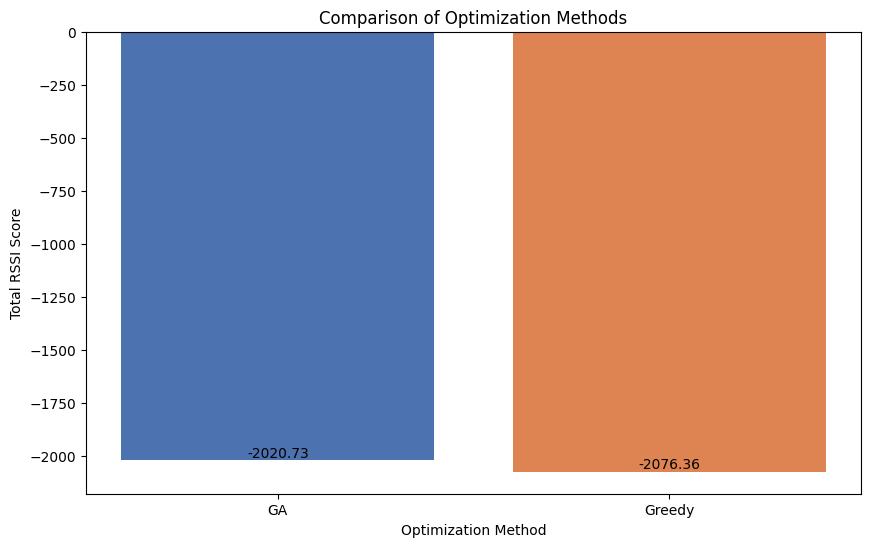

In [ ]:
greedy_ind, greedy_score = run_greedy(
    model=model,
    locations=locations,
    df_synthetic=df_synthetic,
    random_factor=0.3  # Adjust random factor as needed
)

# Run the Limited Knowledge Algorithm
lk_ind, lk_score = run_limited_knowledge(
    model=model,
    locations=locations,
    df_synthetic=df_synthetic,
    max_iterations=10  # Number of iterations to refine search
)

# Visualization (Bar Plot of Results)
methods = ['GA', 'Greedy']
scores = [ga_score, greedy_score]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, scores, color=['#4C72B0', '#DD8452'])
plt.title('Comparison of Optimization Methods')
plt.xlabel('Optimization Method')
plt.ylabel('Total RSSI Score')

# Add max RSSI values on the bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height, f'{score:.2f}', 
        ha='center', va='bottom', fontsize=10, color='black'
    )

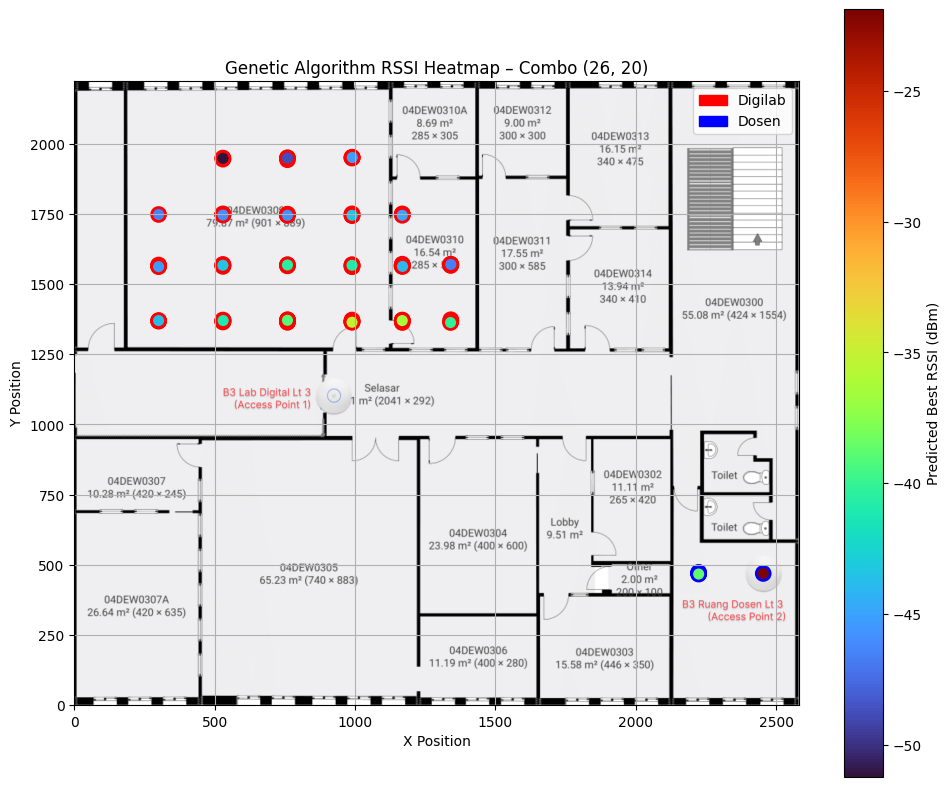

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Use best_ind from the GA result
eval_data = pd.DataFrame({
    'xp': locations['xp'],
    'yp': locations['yp'],
    'dist_to_digilab': locations['dist_to_digilab'],
    'dist_to_dosen': locations['dist_to_dosen'],
    'pow_ap_digilab': best_ind[0],
    'pow_ap_dosen': best_ind[1]
})

# Predict using the model
preds = model.predict(eval_data)

# Merge predictions into location data
df_overlay = locations.copy()
df_overlay['rssi_ap_digilab'] = preds[:, 0]
df_overlay['rssi_ap_dosen'] = preds[:, 1]
df_overlay['best_rssi'] = df_overlay[['rssi_ap_digilab', 'rssi_ap_dosen']].max(axis=1)

# Define which AP each reference point is connected to (based on `best_rssi`)
df_overlay['connected_to'] = np.where(df_overlay['rssi_ap_digilab'] > df_overlay['rssi_ap_dosen'], 'digilab', 'dosen')

# Load floorplan image
floorplan = mpimg.imread('Data/floorplan.png')

# Plot the heatmap overlay
plt.figure(figsize=(10, 8))
plt.imshow(floorplan, extent=[0, floorplan.shape[1], floorplan.shape[0], 0])

# Map the connected AP to edge colors: red for digilab, blue for dosen
edge_colors = df_overlay['connected_to'].map({'digilab': 'red', 'dosen': 'blue'})

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Digilab')
blue_patch = mpatches.Patch(color='blue', label='Dosen')
plt.legend(handles=[red_patch, blue_patch], loc='upper right')


scatter = plt.scatter(
    df_overlay['xp'], df_overlay['yp'],
    c=df_overlay['best_rssi'], cmap='turbo',  # Vibrant colormap for RSSI
    s=100, edgecolors=edge_colors, linewidth=2  # Set edge color based on connected AP
)

# Invert Y-axis to match image coordinates
plt.gca().invert_yaxis()  

# Add colorbar
plt.colorbar(scatter, label='Predicted Best RSSI (dBm)')

# Title and labels
plt.title(f"Genetic Algorithm RSSI Heatmap – Combo {best_ind}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()
